# 🥫 Scraping et Analyse de Données Nutritionnelles avec OpenFoodFacts

## 🎯 Objectif du projet
L’objectif de ce projet est de **scraper automatiquement des données alimentaires** depuis la plateforme **OpenFoodFacts**, une base de données ouverte et collaborative référençant plus de 2 millions de produits à travers le monde.

Nous allons :
1. **Extraire les données** via l’API publique d’OpenFoodFacts (sans téléchargement manuel).
2. **Nettoyer et préparer** ces données pour une analyse statistique.
3. **Visualiser les tendances** (par exemple, les produits les plus courants, les pays producteurs, ou la répartition nutritionnelle).




###  Étape 1 – Scraping automatisé des données

In [2]:
#importation des librairie
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

In [ ]:
#  Scraping avec champs nutritionnels
import requests
import pandas as pd
from time import sleep

categories = ["milk", "chocolate", "rice", "bread", "juice", "snack", "biscuit", "cereal", "yogurt", "cheese"]

# Champs à extraire explicitement
fields = [
    "product_name", "brands", "countries_tags",
    "energy-kcal_100g", "fat_100g", "sugars_100g",
    "proteins_100g", "nutrition-score-fr_100g"
]

produits = []

print("🔍 Scraping en cours...")

for cat in categories:
    for page in range(1, 4):  # 3 pages par catégorie 
        url = (
            f"https://world.openfoodfacts.org/cgi/search.pl?"
            f"search_terms={cat}&json=1&page_size=100&page={page}&fields={','.join(fields)}"
        )
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json().get("products", [])
            produits.extend(data)
        else:
            print(f"❌ Erreur {r.status_code} pour '{cat}' page {page}")
        sleep(1)

df = pd.DataFrame(produits) #converti les produit collecter en dataframe
print(f"\n📊 Total produits collectés : {len(df)}")
print(f"🧭 Colonnes disponibles : {list(df.columns)}")
df.head()


🔍 Scraping en cours...

📊 Total produits collectés : 3000
🧭 Colonnes disponibles : ['brands', 'countries_tags', 'energy-kcal_100g', 'fat_100g', 'nutrition-score-fr_100g', 'product_name', 'proteins_100g', 'sugars_100g']


,brands,countries_tags,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,product_name,proteins_100g,sugars_100g
0,Jaouda,[en:morocco],45.0,1.5,-3.0,Lait,3.1,0.0
1,MILKY FOOD PROFESSIONAL,[en:morocco],80.6,12.0,-2.0,Fromage blanc nature,7.3,0.0
2,Jaouda,"[en:democratic-republic-of-the-congo, en:mauri...",58.0,3.0,-1.0,uht jaouda 1L,3.0,0.0
3,Jaouda,"[en:morocco, en:maroc]",235.0,21.0,11.0,Jben,8.0,0.0
4,"Marmite,Unilever","[en:france, en:germany, en:ireland, en:italy, ...",260.0,0.5,23.0,Marmite Yeast Extract,34.0,1.2


### 🔍 Étape 2 – Exploration des données brutes

Avant de passer au nettoyage, observons les colonnes disponibles et les premières lignes du DataFrame.


In [48]:
df.info()
df.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brands                   2935 non-null   object 
 1   countries_tags           3000 non-null   object 
 2   energy-kcal_100g         2932 non-null   float64
 3   fat_100g                 2946 non-null   float64
 4   nutrition-score-fr_100g  2768 non-null   float64
 5   product_name             2978 non-null   object 
 6   proteins_100g            2942 non-null   float64
 7   sugars_100g              2901 non-null   float64
dtypes: float64(5), object(3)
memory usage: 187.6+ KB


,brands,countries_tags,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,product_name,proteins_100g,sugars_100g
1920,Gerblé,"[en:belgium, en:france, en:morocco, en:reunion...",457.0,19.0,2.0,Biscuits Soja Figue,12.0,15.0
2961,"Etorki, Savencia","[en:france, en:switzerland]",393.0,33.0,14.0,Etorki pur brebis,24.0,0.5
543,ColaCao,"[en:france, en:spain]",324.0,5.8,4.0,ColaCao Cero,12.0,3.5
1706,"Natu' & Bon,Vico",[en:france],452.0,19.0,8.0,Chips de lentilles saveur tomate mozza,13.0,3.8
2130,Nature ValleyGeneral Mills,[en:france],467.0,18.1,14.0,Crunchy avoine et miel,8.7,26.8


### 🧹 Étape 3 – Exploration et nettoyage des données

Avant d’analyser, il est important de vérifier la qualité des données récupérées.
Nous allons :
- Identifier les colonnes les plus pertinentes pour notre analyse.
- Supprimer les valeurs manquantes ou inutiles.
- Normaliser les noms et types de colonnes.

Cela garantira une base de données exploitable et propre.


In [49]:

# On renomme les colonnes importantes et on conserve celles pertinentes pour notre analyse

df_clean = df.rename(columns={
    "product_name": "Produit",
    "brands": "Marque",
    "countries_tags": "Pays",
    "energy-kcal_100g": "Énergie (kcal/100g)",
    "fat_100g": "Graisse (g/100g)",
    "sugars_100g": "Sucres (g/100g)",
    "proteins_100g": "Protéines (g/100g)",
    "nutrition-score-fr_100g": "Score nutritionnel"
})

# On garde seulement les colonnes disponibles
colonnes_finales = [col for col in [
    "Produit", "Marque", "Pays", "Énergie (kcal/100g)",
    "Graisse (g/100g)", "Sucres (g/100g)", "Protéines (g/100g)", "Score nutritionnel"
] if col in df_clean.columns]

df_clean = df_clean[colonnes_finales].dropna(subset=["Produit"], how="all")

print(f"✅ Données nettoyées : {df_clean.shape[0]} produits exploitables.")
print(f"📋 Colonnes finales : {list(df_clean.columns)}")
df_clean.head()


✅ Données nettoyées : 2978 produits exploitables.
📋 Colonnes finales : ['Produit', 'Marque', 'Pays', 'Énergie (kcal/100g)', 'Graisse (g/100g)', 'Sucres (g/100g)', 'Protéines (g/100g)', 'Score nutritionnel']


,Produit,Marque,Pays,Énergie (kcal/100g),Graisse (g/100g),Sucres (g/100g),Protéines (g/100g),Score nutritionnel
0,Lait,Jaouda,[en:morocco],45.0,1.5,0.0,3.1,-3.0
1,Fromage blanc nature,MILKY FOOD PROFESSIONAL,[en:morocco],80.6,12.0,0.0,7.3,-2.0
2,uht jaouda 1L,Jaouda,"[en:democratic-republic-of-the-congo, en:mauri...",58.0,3.0,0.0,3.0,-1.0
3,Jben,Jaouda,"[en:morocco, en:maroc]",235.0,21.0,0.0,8.0,11.0
4,Marmite Yeast Extract,"Marmite,Unilever","[en:france, en:germany, en:ireland, en:italy, ...",260.0,0.5,1.2,34.0,23.0


## Étape 4 — Nettoyage approfondi et Analyse exploratoire (EDA)

Dans cette partie, nous allons :
- Évaluer la qualité des données collectées,
- Nettoyer les valeurs manquantes et incohérentes,
- Explorer la distribution des variables nutritionnelles,
- Identifier les relations entre calories, sucres, graisses et protéines.

Ces étapes permettent de préparer le jeu de données à une analyse statistique ou à une visualisation (Power BI, Python.).


In [50]:
# Aperçu du DataFrame
print("Dimensions du dataset :", df_clean.shape)
print("\nAperçu des 5 premières lignes :")
display(df_clean.head())

# Informations générales sur les colonnes
print("\nRésumé des types de données :")
print(df_clean.info())


Dimensions du dataset : (2978, 8)

Aperçu des 5 premières lignes :


,Produit,Marque,Pays,Énergie (kcal/100g),Graisse (g/100g),Sucres (g/100g),Protéines (g/100g),Score nutritionnel
0,Lait,Jaouda,[en:morocco],45.0,1.5,0.0,3.1,-3.0
1,Fromage blanc nature,MILKY FOOD PROFESSIONAL,[en:morocco],80.6,12.0,0.0,7.3,-2.0
2,uht jaouda 1L,Jaouda,"[en:democratic-republic-of-the-congo, en:mauri...",58.0,3.0,0.0,3.0,-1.0
3,Jben,Jaouda,"[en:morocco, en:maroc]",235.0,21.0,0.0,8.0,11.0
4,Marmite Yeast Extract,"Marmite,Unilever","[en:france, en:germany, en:ireland, en:italy, ...",260.0,0.5,1.2,34.0,23.0



Résumé des types de données :
<class 'pandas.core.frame.DataFrame'>
Index: 2978 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Produit              2978 non-null   object 
 1   Marque               2928 non-null   object 
 2   Pays                 2978 non-null   object 
 3   Énergie (kcal/100g)  2920 non-null   float64
 4   Graisse (g/100g)     2933 non-null   float64
 5   Sucres (g/100g)      2891 non-null   float64
 6   Protéines (g/100g)   2928 non-null   float64
 7   Score nutritionnel   2760 non-null   float64
dtypes: float64(5), object(3)
memory usage: 209.4+ KB
None


In [51]:
#valeur manquantes avec isnull
missing_values = df_clean.isnull().sum()
print(missing_values)


# Pourcentage de valeurs manquantes par colonne
missing = df_clean.isna().mean().round(3) * 100
print("📊 Pourcentage de valeurs manquantes (%):\n")
print(missing)



Produit                  0
Marque                  50
Pays                     0
Énergie (kcal/100g)     58
Graisse (g/100g)        45
Sucres (g/100g)         87
Protéines (g/100g)      50
Score nutritionnel     218
dtype: int64
📊 Pourcentage de valeurs manquantes (%):

Produit                0.0
Marque                 1.7
Pays                   0.0
Énergie (kcal/100g)    1.9
Graisse (g/100g)       1.5
Sucres (g/100g)        2.9
Protéines (g/100g)     1.7
Score nutritionnel     7.3
dtype: float64


In [52]:
# On supprime les produits sans informations nutritionnelles de base
colonnes_nutrition = [
    "Énergie (kcal/100g)", "Graisse (g/100g)",
    "Sucres (g/100g)", "Protéines (g/100g)"
]
df_clean = df_clean.dropna(subset=colonnes_nutrition, how="any")

# Conversion des colonnes numériques en float
for col in colonnes_nutrition:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print(f"✅ Données après nettoyage : {df_clean.shape[0]} produits exploitables.")


✅ Données après nettoyage : 2873 produits exploitables.


### STATISTIQUES DE BASE ET VISUALISATION ###

In [53]:
# Statistiques de base sur les variables nutritionnelles
df_clean.describe()[colonnes_nutrition]


,Énergie (kcal/100g),Graisse (g/100g),Sucres (g/100g),Protéines (g/100g)
count,2873.000000,2873.000000,2873.000000,2873.000000
mean,297.123779,12.478043,12.578213,7.262166
std,241.087855,13.207727,15.216774,5.374728
min,0.000000,0.000000,0.000000,0.000000
25%,101.000000,1.800000,2.300000,3.900000
50%,295.000000,7.000000,5.400000,7.000000
75%,448.000000,21.000000,18.000000,9.500000
max,5280.000000,84.000000,119.000000,97.500000


### 🔍 Matrice de corrélation et heatmap — objectif et interprétation

Objectif : calculer la corrélation entre les variables nutritionnelles (énergie, graisses, sucres, protéines) afin d'identifier les relations linéaires fortes entre elles.  
La heatmap permet de visualiser rapidement ces relations et d'afficher les coefficients de corrélation.



In [54]:
# Matrice de corrélation
corr = df_clean[["Énergie (kcal/100g)", "Graisse (g/100g)", "Sucres (g/100g)", "Protéines (g/100g)"]].corr()
print("📈 Matrice de corrélation :\n")
display(corr)


📈 Matrice de corrélation :



,Énergie (kcal/100g),Graisse (g/100g),Sucres (g/100g),Protéines (g/100g)
Énergie (kcal/100g),1.000000,0.628806,0.396420,0.427210
Graisse (g/100g),0.628806,1.000000,0.417022,0.329205
Sucres (g/100g),0.396420,0.417022,1.000000,-0.104683
Protéines (g/100g),0.427210,0.329205,-0.104683,1.000000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


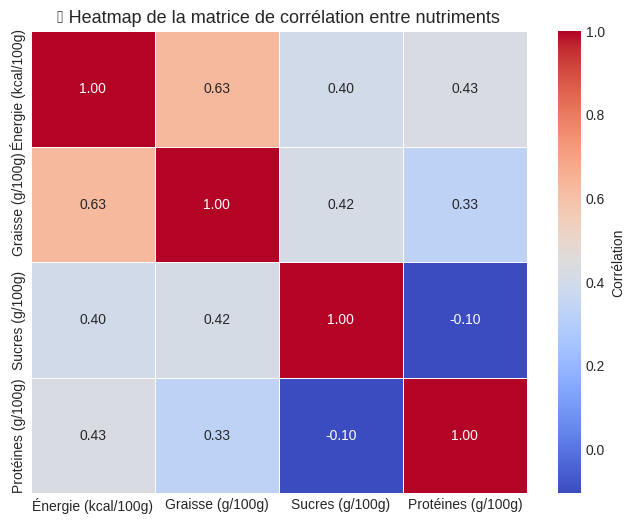

In [55]:
#heatmap de la matrice de correlation avec valeur
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Corrélation"}
)
plt.title("🔍 Heatmap de la matrice de corrélation entre nutriments", fontsize=13)
plt.show()


###  Analyse des produits les plus gras

Dans cette section, nous identifions les **10 produits les plus riches en graisses** du dataset.  
L’objectif est de repérer les aliments potentiellement les plus caloriques ou les moins recommandés pour une alimentation équilibrée.  
Cette analyse permet de mieux comprendre quels types de produits ou marques présentent les plus fortes teneurs en matières grasses.


/tmp/ipython-input-2665325403.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127828 (\N{HAMBURGER}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


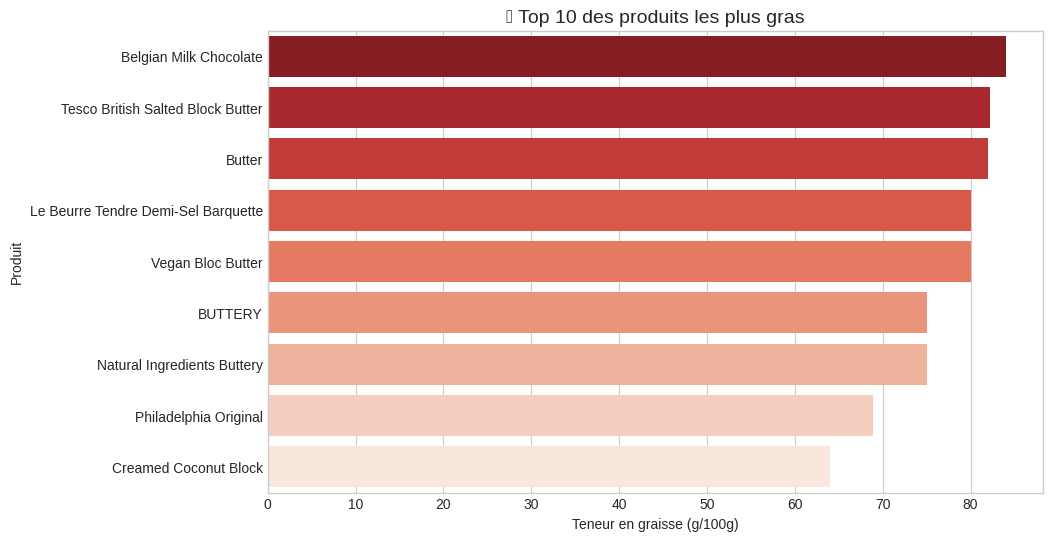

,Produit,Graisse (g/100g),Marque
656,Belgian Milk Chocolate,84.0,Kallø
106,Tesco British Salted Block Butter,82.2,Tesco
90,Butter,82.0,Lurpak
94,Le Beurre Tendre Demi-Sel Barquette,80.0,"Elle & Vire, Savencia"
1197,Vegan Bloc Butter,80.0,M-Classic


In [56]:
# 🧈 Top 10 des produits les plus gras (en g/100g)
top_fat = df_clean.nlargest(10, 'Graisse (g/100g)')[['Produit', 'Graisse (g/100g)', 'Marque']]

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_fat,
    y='Produit', x='Graisse (g/100g)',
    palette='Reds_r'
)
plt.title("🍔 Top 10 des produits les plus gras", fontsize=14)
plt.xlabel("Teneur en graisse (g/100g)")
plt.ylabel("Produit")
plt.show()

top_fat.head()



###  Produits avec le meilleur score nutritionnel

Nous analysons ici les **produits les plus sains** selon le `nutrition_score_100g`.  
Ce score (plus il est bas, meilleur est le produit) résume plusieurs éléments : graisses, sucres, fibres, protéines, etc.  
Cette visualisation permet de valoriser les produits les plus équilibrés et d’identifier les marques qui proposent des options saines.


/tmp/ipython-input-490554592.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


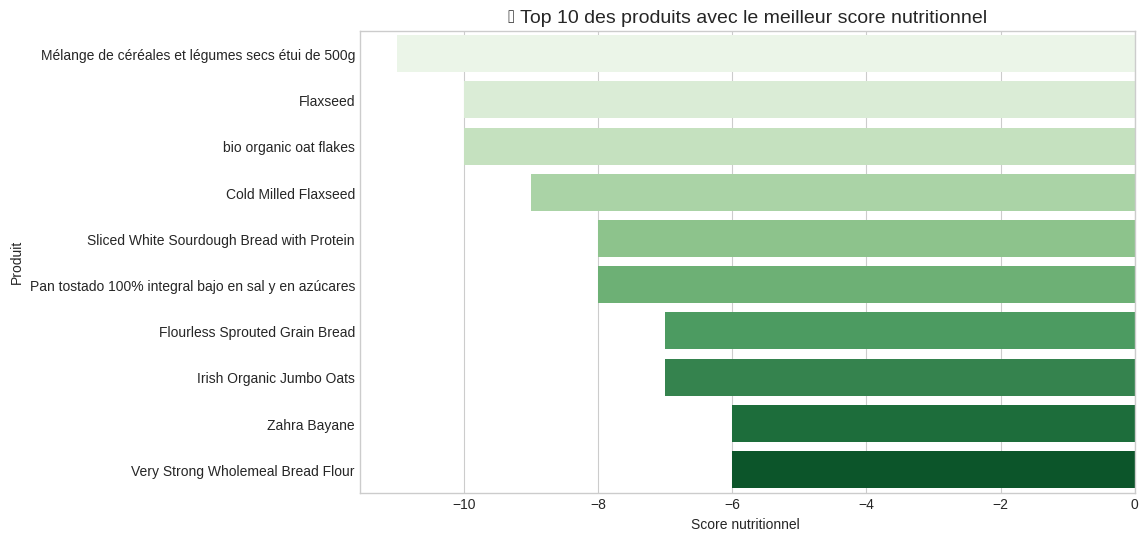

In [57]:
# 🥦 Top 10 des produits avec le meilleur score nutritionnel
if 'Score nutritionnel' in df_clean.columns:
    top_nutri = df_clean.nsmallest(10, 'Score nutritionnel')[['Produit', 'Score nutritionnel', 'Marque']]

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=top_nutri,
        y='Produit', x='Score nutritionnel',
        palette='Greens'
    )
    plt.title("🥇 Top 10 des produits avec le meilleur score nutritionnel", fontsize=14)
    plt.xlabel("Score nutritionnel ")
    plt.ylabel("Produit")
    plt.show()

    top_nutri.head()
else:
    print("⚠️ Pas de colonne 'nutrition_score_100g' dans les données.")


### 🚨 Produits les moins bons nutritionnellement

Pour terminer, nous identifions les **10 produits ayant les plus mauvais scores nutritionnels**.  
Ce sont les produits les plus riches en graisses saturées, sucres ou sel, donc à consommer avec modération.  
L’objectif est de repérer les extrêmes pour mieux comprendre la variabilité de la qualité nutritionnelle des produits.


/tmp/ipython-input-3857183608.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


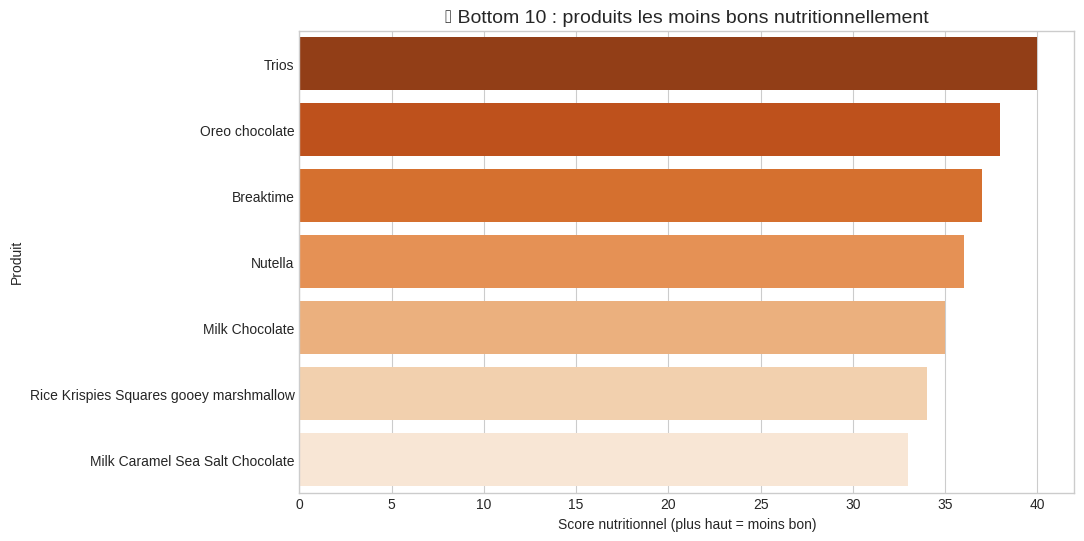

In [58]:

# 🍩 Bottom 10 des produits avec le score nutritionnel le plus mauvais
if 'Score nutritionnel' in df_clean.columns:
    bottom_nutri = df_clean.nlargest(10, 'Score nutritionnel')[['Produit', 'Score nutritionnel', 'Marque']]

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=bottom_nutri,
        y='Produit', x='Score nutritionnel',
        palette='Oranges_r'
    )
    plt.title("🚨 Bottom 10 : produits les moins bons nutritionnellement", fontsize=14)
    plt.xlabel("Score nutritionnel (plus haut = moins bon)")
    plt.ylabel("Produit")
    plt.show()

    bottom_nutri.head()


### 🌍 Répartition des produits par pays

 nous visualisons la **répartition des produits selon leur pays d’origine**.  
Ce graphique en camembert (pie chart) permet de comprendre la proportion de produits présents par pays dans le dataset.  
C’est utile pour voir quels pays sont les plus représentés dans la base OpenFoodFacts que nous avons extraite.


### 🧹 Nettoyage des noms de pays

Avant de tracer le camembert, il est essentiel d’uniformiser les noms de pays.  
En effet, certaines valeurs comme *"fr"*, *"france"* ou *"en:france"* peuvent représenter le même pays.  
Nous allons donc :
- Convertir tous les noms en minuscules,
- Extraire uniquement le nom principal s’il y a plusieurs tags,
- Et capitaliser correctement pour un affichage homogène.


In [ ]:
import re

def corriger_pays(p):
    #  valeur manquante
    if p is None or (isinstance(p, float) and pd.isna(p)):
        return "Inconnu"

    #  si c’est une liste
    if isinstance(p, list):
        if len(p) == 0:
            return "Inconnu"
        p = p[0]  # on garde le premier élément

    #  si c’est une chaîne
    if isinstance(p, str):
        # garde seulement le premier pays si plusieurs séparés par des virgules
        p = p.split(",")[0].strip()
        # enlève les préfixes de langue type "en:" ou "fr:"
        p = re.sub(r'^[a-z]{2}:', '', p)
        # nettoie la casse et supprime les espaces
        p = p.lower().strip().capitalize()
        # valeur par défaut si vide après nettoyage
        return p if p else "Inconnu"

    #  Cas par défaut
    return "Inconnu"

# Application du nettoyage
df_clean["Pays"] = df_clean["Pays"].apply(corriger_pays)

# Vérification
print(df_clean["Pays"].unique()[:10])


['Morocco' 'Democratic-republic-of-the-congo' 'France' 'Algeria' 'Albania'
 'Germany' 'United-kingdom' 'Ireland' 'Belgium' 'Greece']


In [ ]:
import re

def corriger_nom(p):
    #  valeur manquante
    if p is None or (isinstance(p, float) and pd.isna(p)):
        return "Inconnu"

    #  si c’est une liste
    if isinstance(p, list):
        if len(p) == 0:
            return "Inconnu"
        p = p[0]  # on garde le premier élément

    #  si c’est une chaîne
    if isinstance(p, str):
        # garde seulement le premier pays si plusieurs séparés par des virgules
        p = p.split(",")[0].strip()
        # enlève les préfixes de langue type "en:" ou "fr:"
        p = re.sub(r'^[a-z]{2}:', '', p)
        # nettoie la casse et supprime les espaces
        p = p.lower().strip().capitalize()
        # valeur par défaut si vide après nettoyage
        return p if p else "Inconnu"

    #  Cas par défaut
    return "Inconnu"

# Application du nettoyage
df_clean["Produit"] = df_clean["Produit"].apply(corriger_nom)

# Vérification
print(df_clean["Produit"].unique()[:10])


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


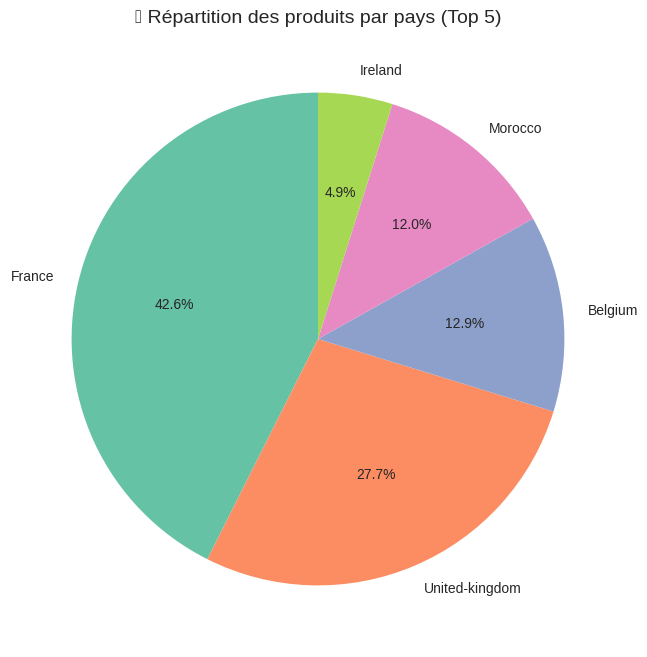

In [ ]:
# 🌍 Répartition des produits par pays
plt.figure(figsize=(8, 8))

# Comptage des produits par pays
pays_counts = df_clean['Pays'].value_counts().head(5)  # on affiche les 5 premiers pays

plt.pie(
    pays_counts,
    labels=pays_counts.index,
    autopct='%1.1f%%',      # affiche les pourcentages
    startangle=90,
    colors=sns.color_palette('Set2'),
    explode=[0.05]*len(pays_counts)  # détache légèrement les parts
)

plt.title("🌍 Répartition des produits par pays (Top 5)", fontsize=14)
plt.show()


### 📊 Top 10 des pays les plus représentés

Le graphique ci-dessous montre les **10 pays ayant le plus grand nombre de produits** enregistrés dans le dataset.  


Cette visualisation met en évidence les pays les plus présents dans la base OpenFoodFacts,  
ce qui peut refléter à la fois la taille de leur marché alimentaire et leur degré de contribution à la plateforme.


In [63]:
import re

def corriger_pays(p):
    # 🧩 Cas 1 : valeur manquante
    if p is None or (isinstance(p, float) and pd.isna(p)):
        return "Inconnu"

    # 🧩 Cas 2 : si c’est une liste
    if isinstance(p, list):
        if len(p) == 0:
            return "Inconnu"
        p = p[0]  # on garde le premier élément

    # 🧩 Cas 3 : si c’est une chaîne
    if isinstance(p, str):
        # garde seulement le premier pays si plusieurs séparés par des virgules
        p = p.split(",")[0].strip()
        # enlève les préfixes de langue type "en:" ou "fr:"
        p = re.sub(r'^[a-z]{2}:', '', p)
        # nettoie la casse et supprime les espaces
        p = p.lower().strip().capitalize()
        # valeur par défaut si vide après nettoyage
        return p if p else "Inconnu"

    # 🧩 Cas par défaut
    return "Inconnu"

# Application du nettoyage
df_clean["Pays"] = df_clean["Pays"].apply(corriger_pays)

# Vérification
print(df_clean["Pays"].unique()[:10])


['Morocco' 'Democratic-republic-of-the-congo' 'France' 'Algeria' 'Albania'
 'Germany' 'United-kingdom' 'Ireland' 'Belgium' 'Greece']


/tmp/ipython-input-1276691262.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


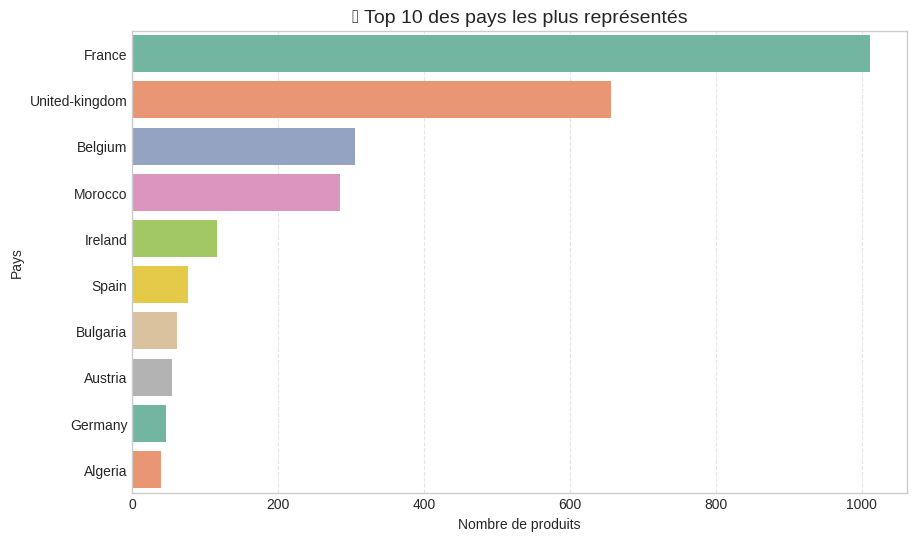

In [66]:
# 📊 Top 10 des pays les plus représentés
plt.figure(figsize=(10,6))

pays_counts = df_clean['Pays'].value_counts().head(10)

sns.barplot(
    x=pays_counts.values,
    y=pays_counts.index,
    palette='Set2'
)

plt.title("📊 Top 10 des pays les plus représentés", fontsize=14)
plt.xlabel("Nombre de produits")
plt.ylabel("Pays")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


## 🧩 Conclusion : Données nettoyées et prêtes pour l’analyse

Nous avons :
- Collecté les données OpenFoodFacts via l’API.
- Nettoyé les doublons, valeurs manquantes et incohérences.
- Uniformisé les colonnes numériques (graisse, sucre, protéines, énergie, score nutritionnel…).
- Corrigé et standardisé les pays, les noms de produits et les marques.
- Réalisé plusieurs visualisations :
  - ✅ Heatmap de la matrice de corrélation.
  - ✅ Top produits les plus gras.
  - ✅ Top produits avec le meilleur score nutritionnel.
  - ✅ Bottom produits avec le plus faible score nutritionnel.
  - ✅ Répartition des pays (camembert et barplot).

### 🎯 Résultat final :
Notre dataset nettoyé contient **≈ 3000 produits exploitables** avec des informations nutritionnelles cohérentes.
Ces données sont désormais **prêtes pour des analyses approfondies ou des modèles de machine learning**.


In [67]:
# 💾 Sauvegarde du dataset propre
output_path = "openfoodfacts_cleaned.csv"
df_clean.to_csv(output_path, index=False)

print(f"✅ Dataset nettoyé et normalisé sauvegardé sous : {output_path}")
print(f"Nombre total de produits : {len(df_clean)}")
print(f"Colonnes finales : {list(df_clean.columns)}")


✅ Dataset nettoyé et normalisé sauvegardé sous : openfoodfacts_cleaned.csv
Nombre total de produits : 2873
Colonnes finales : ['Produit', 'Marque', 'Pays', 'Énergie (kcal/100g)', 'Graisse (g/100g)', 'Sucres (g/100g)', 'Protéines (g/100g)', 'Score nutritionnel']


In [71]:
import os
print(os.getcwd())
!ls -lh


/content
total 196K
-rw-r--r-- 1 root root 192K Nov 13 11:39 openfoodfacts_cleaned.csv
drwxr-xr-x 1 root root 4.0K Nov 11 14:29 sample_data


In [75]:
from google.colab import files
files.download("openfoodfacts_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>